<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [1]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

redpath ="/home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/"

A routine to display in image

In [2]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

<h3> Find the stars in your image</h3>

In [3]:
#filename should be the name of the combined image file (without path) that has the original header
#wcsfilename should be the name of the image that has the correct WCS header, e.g. one output
#by astrometry.net. 
def read_one_image(filename, wcsfilename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)
    wcsfile = os.path.join('{}'.format(redpath), wcsfilename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    wcshdr = fits.getheader(wcsfile)

    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(wcshdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [4]:
img_ngc7296_V, hdr_ngc7296_V, imgwcs_ngc7296_V, imgfile_ngc7296_V = read_one_image('ngc7296_V_comb.fits','wngc7296_V_comb.fits',redpath)
img_ngc7296_B, hdr_ngc7296_B, imgwcs_ngc7296_B, imgfile_ngc7296_B = read_one_image('ngc7296_B_comb.fits','wngc7296_B_comb.fits',redpath)

img_king20_V, hdr_king20_V, imgwcs_king20_V, imgfile_king20_V = read_one_image('king20_V_comb.fits','wking20_V_comb.fits',redpath)
img_king20_B, hdr_king20_B, imgwcs_king20_B, imgfile_king20_B = read_one_image('king20_B_comb.fits','wking20_B_comb.fits',redpath)

Reading /home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/ngc7296_V_comb.fits
Reading /home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/ngc7296_B_comb.fits
Reading /home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/king20_V_comb.fits
Reading /home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/king20_B_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [5]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [6]:
#***********
bkg_V = get_sky_background(img_ngc7296_V, verbose=True)
img_ngc7296_V_nosky = img_ngc7296_V - bkg_V.background

bkg_B = get_sky_background(img_ngc7296_B, verbose=True)
img_ngc7296_B_nosky = img_ngc7296_B - bkg_B.background


bkg_V2 = get_sky_background(img_king20_V, verbose=True)
img_king20_V_nosky = img_king20_V - bkg_V2.background

bkg_B2 = get_sky_background(img_king20_B, verbose=True)
img_king20_B_nosky = img_king20_B - bkg_B2.background




Sky background median = 2.170, rms = 0.065 electrons.
Sky background median = 1.894, rms = 0.051 electrons.
Sky background median = 1.974, rms = 0.052 electrons.
Sky background median = 1.686, rms = 0.047 electrons.


In [9]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

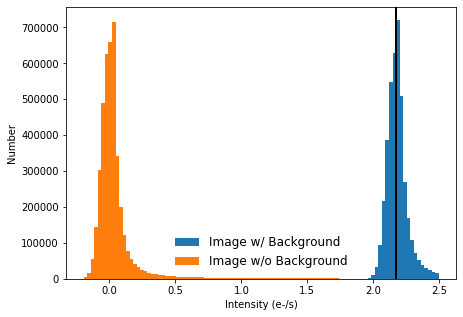

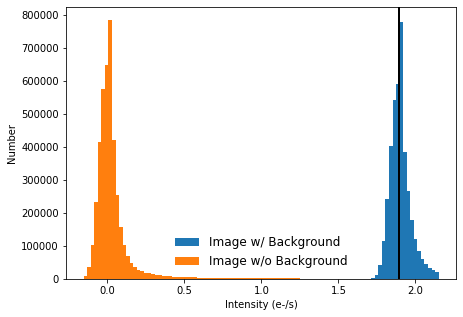

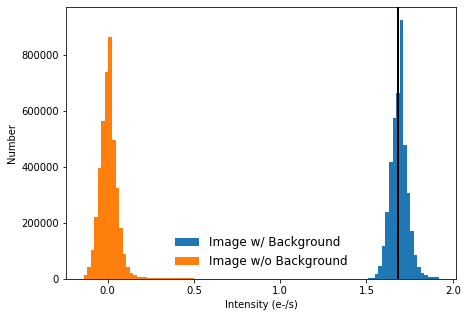

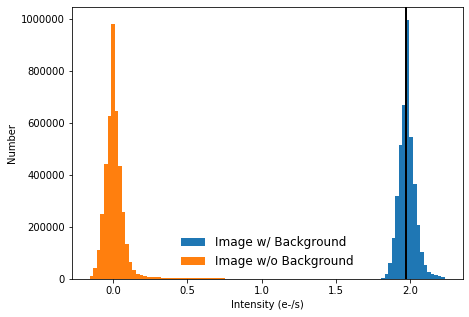

In [10]:
#***********
qa_background(img_ngc7296_V, img_ngc7296_V_nosky,bkg_V)



qa_background(img_ngc7296_B, img_ngc7296_B_nosky,bkg_B)

qa_background(img_king20_B, img_king20_B_nosky,bkg_B2)


qa_background(img_king20_V, img_king20_V_nosky,bkg_V2)

This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*
*viewer=imexam.connect()*
*viewer.load_fits('<filename>')*
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [11]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm, nsigma, sigma, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [13]:
#### avg FWHM's

AFWHM_NGC7296_B=4.3885
AFWHM_NGC7296_V=4.785727273
AFWHM_KING20_B=4.185090909
AFWHM_KING20_V=4.135





#***********
srcs_ngc7296_V = find_stars(img_ngc7296_V_nosky, imgfile_ngc7296_V,fwhm=AFWHM_NGC7296_V, sigma=bkg_V.background_rms_median, nsigma=3, 
                  verbose=True, overwrite=False)
srcs_ngc7296_V

srcs_king20_V=find_stars(img_king20_V_nosky, imgfile_king20_V,fwhm=AFWHM_KING20_V, sigma=bkg_V2.background_rms_median, nsigma=3, 
                  verbose=True, overwrite=False)
srcs_king20_V

Read 2308 stars from /home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/stars-ngc7296_V_comb.fits
Read 1284 stars from /home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/stars-king20_V_comb.fits


<Table length=1284>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  511  87.22229990665448 ... 2666.3490977331157     -8.564792524447869
  332 1824.8993192954665 ...  2436.507366896397     -8.466919322073519
  673  999.9303560458535 ...  2219.773200644574     -8.365771509617296
  657 1301.2651834242145 ... 2135.4441491541975     -8.323720543210275
  757 1348.7260567462836 ... 1992.8577365885963      -8.24869074246148
  106  1302.805602117201 ...  1857.743042487032     -8.172464108714333
  508  87.51218228289451 ...  1819.357939918343      -8.14979537607908
  507  86.71650837055607 ... 1806.6242622998407       -8.1421695958771
 1199  789.1060461041279 ...  1469.334503538037     -7.917801692510556
  924  236.4385114564687 ... 1465.3942620883008     -7.914886216696788
  ...                ... ...                ...                    ...
  514 1139.1270484071904 ... 1.0117986963391004  -0.012735288755942126
  682 1235.7846098696723 ... 1.0117518416810305  -0.012685009014782929
  340 1891.3672224592717 ...  1.008194038209867  -0.008860312451291777
  964 1694.0332387413728 ... 1.0069606811091805  -0.007531282365433283
  458  320.5233117496827 ...  1.006282880864031  -0.006800211065907036
  843 1842.3191882362896 ... 1.0061594371245417  -0.006667012378735455
  296  1726.662393873095 ... 1.0049181097380009  -0.005326681908845165
  769 211.35955117045924 ... 1.0039832409307805  -0.004316158436766975
  672 1716.9473362580545 ... 1.0038591633378782  -0.004181969085353348
  165  684.3599575767101 ... 1.0014852294772587 -0.0016113710839088715

In [14]:
srcs_ngc7296_B = find_stars(img_ngc7296_B_nosky, imgfile_ngc7296_B, fwhm=AFWHM_NGC7296_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7296_B

srcs_king20_B=find_stars(img_king20_B_nosky, imgfile_king20_B,fwhm=AFWHM_KING20_B, sigma=bkg_B2.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_king20_B

Read 2070 stars from /home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/stars-ngc7296_B_comb.fits
Read 719 stars from /home/s376r951/RFSLAB/USER_DPT/s376r951/Data/Reduced_Complete/combo/stars-king20_B_comb.fits


<Table length=719>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  266  87.02466681963199 ... 2211.6869835502484      -8.36180915498107
  366  999.9684368956684 ...  2125.945053357191     -8.318880089165106
  174 1824.9253508809338 ... 1436.5288842953828     -7.893285906944147
  355   1301.26637670448 ... 1382.9784816632803    -7.8520385569840485
  676   789.122543188684 ...  936.9336072250413     -7.429272042754683
  495 1015.3797690710736 ...  927.3349286062709     -7.418091545109528
   63  486.9841579053291 ...  737.7758998039653     -7.169811161134865
  528 236.47902919634095 ...  640.1927183458811     -7.015776825253697
   46  1302.905575122393 ...  574.5824209269293     -6.898380837070482
  238  800.2532425751701 ...  447.8399288441499     -6.627807030296088
  ...                ... ...                ...                    ...
  643  467.6601893590336 ... 1.0157277598246734  -0.016943304689912023
  240  390.6311152963382 ... 1.0135089254645513  -0.014568944148628905
  274 1834.5682183849788 ... 1.0133646769345022   -0.01441440481116206
  503 130.91482786148123 ... 1.0107182680312428  -0.011575288357688885
  404 340.02201556301145 ... 1.0086258209827803  -0.009325204934543023
  567 1021.0584582025248 ... 1.0072181022398128  -0.007808806332252458
   29 1533.6110091688965 ...  1.006845600444658 -0.0074071917364386345
  196  382.4510054851117 ... 1.0058693425440328  -0.006353929192025777
  573 1951.7947803968918 ... 1.0057389241443153   -0.00621314633595667
  587  714.6609139871952 ... 1.0053856857645784  -0.005831744109714966

<h3> Use stars from Pan-STARRS</h3>

We will be using the large survey called Pan-STARRS (https://panstarrs.stsci.edu/).  Pan-STARRS uses SDSS filters (*griz*), which are different from the "Johnson" *BVR* filters that we are using.  But there are transformation between these filters such that if we know the Pan-STARRS magnitudes of a given object, we can determine its B-V color.

This routine sends a request to a catalog server at a remote location and pulls back all the photometry

In [15]:
def get_panstarrs_catalog(imgwcs, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    

    #we limit ourselves to bright objects so that we know that they will have high Signal-to-Noise
    rmag = allcat['rMeanPSFMag']
    good = np.isfinite(rmag) * rmag < rfaint
    cat = allcat[good]
    print('Keeping {}/{} Pan-STARRS sources with rmag< {}.'.format(len(cat), len(allcat),rfaint))
    
    #make B and V-band magnitudes using the transformations published in Tonry et al. (2012)
    #https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T/abstract
    cat['B'] = 0.213 + 0.587 * (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['gMeanPSFMag'] 
    cat['V'] = 0.006 + 0.474 *  (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['rMeanPSFMag'] 
    
    return cat

In [16]:
%time refcat_ngc7296_V = get_panstarrs_catalog(imgwcs_ngc7296_V, radius=0.2)
refcat_ngc7296_V

%time refcat_king20_V = get_panstarrs_catalog(imgwcs_king20_V, radius=0.2)
refcat_king20_V


Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=336.99841,52.31030


Keeping 1875/2426 Pan-STARRS sources with rmag< 17.
CPU times: user 360 ms, sys: 67 ms, total: 427 ms
Wall time: 4.03 s
Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.31940,58.47552
Keeping 643/652 Pan-STARRS sources with rmag< 17.
CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 2.73 s


<Table masked=True length=643>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
177973533643142604 353.36438085 ... 13.106981146812439 12.278481775283813
178253534222408649 353.42222936 ... 13.765923689842225 12.689336183547974
178063533638825273  353.3639764 ...  13.02220694923401 12.524714305877685
178193533621090461 353.36215886 ... 13.630024438858031 12.808648387908935
178003535709165660 353.57091598 ...  13.43149608707428 12.770392095565796
178243534353808280 353.43544285 ... 14.003855922698975 13.031112228393555
177973531027574158 353.10279647 ... 13.910222898483276 13.003146221160888
177943533354839104 353.33555251 ... 15.151532992362975 13.575877855300904
178283534833775064 353.48342907 ...   13.9078879737854 13.228976211547852
178203532822397719 353.28226479 ... 13.870125274658204 13.245750274658203
               ...          ... ...                ...                ...
178303533587926326 353.35876197 ...  18.75672840118408 17.440846786499023
178103532385686076 353.23854466 ... 18.719216722488405 17.436725872039794
178303530050130860 353.00500804 ...  18.55760074234009   17.3936450881958
177953533551475774 353.35513306 ...  18.26874841117859 17.308913944244384
178283536222115729   353.622211 ... 17.761384883880616  17.15927039337158
178053535274722220 353.52743711 ...  18.70315467262268 17.444482524871827
178043533328551756 353.33284466 ...  18.74243766593933 17.456495014190672
177973531140951246 353.11407417 ... 18.519226211547853 17.391440170288085
178183532549873352 353.25495598 ...   18.7033556060791 17.447908111572264
178123531943045190 353.19428958 ... 18.778003078460692 17.472026817321776

In [17]:
%time refcat_ngc7296_B = get_panstarrs_catalog(imgwcs_ngc7296_B, radius=0.2)
refcat_ngc7296_B
%time refcat_king20_B = get_panstarrs_catalog(imgwcs_king20_B, radius=0.2)
refcat_king20_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=336.99843,52.31030
Keeping 1875/2426 Pan-STARRS sources with rmag< 17.
CPU times: user 41 ms, sys: 458 µs, total: 41.5 ms
Wall time: 3.2 s
Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.31941,58.47552
Keeping 643/652 Pan-STARRS sources with rmag< 17.
CPU times: user 27.2 ms, sys: 291 µs, total: 27.5 ms
Wall time: 2.87 s


<Table masked=True length=643>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
177973533643142604 353.36438085 ... 13.106981146812439 12.278481775283813
178253534222408649 353.42222936 ... 13.765923689842225 12.689336183547974
178063533638825273  353.3639764 ...  13.02220694923401 12.524714305877685
178193533621090461 353.36215886 ... 13.630024438858031 12.808648387908935
178003535709165660 353.57091598 ...  13.43149608707428 12.770392095565796
177973531027574158 353.10279647 ... 13.910222898483276 13.003146221160888
178243534353808280 353.43544285 ... 14.003855922698975 13.031112228393555
177943533354839104 353.33555251 ... 15.151532992362975 13.575877855300904
178283534833775064 353.48342907 ...   13.9078879737854 13.228976211547852
178203532822397719 353.28226479 ... 13.870125274658204 13.245750274658203
               ...          ... ...                ...                ...
178303533587926326 353.35876197 ...  18.75672840118408 17.440846786499023
178103532385686076 353.23854466 ... 18.719216722488405 17.436725872039794
178303530050130860 353.00500804 ...  18.55760074234009   17.3936450881958
177953533551475774 353.35513306 ...  18.26874841117859 17.308913944244384
178283536222115729   353.622211 ... 17.761384883880616  17.15927039337158
178053535274722220 353.52743711 ...  18.70315467262268 17.444482524871827
178043533328551756 353.33284466 ...  18.74243766593933 17.456495014190672
177973531140951246 353.11407417 ... 18.519226211547853 17.391440170288085
178183532549873352 353.25495598 ...   18.7033556060791 17.447908111572264
178123531943045190 353.19428958 ... 18.778003078460692 17.472026817321776

We need to match the Pan-STARRS catalog against ours.  First we need to compute the nearest Pan-STARRS star to each of ours and look at the distribution of distances to find the optimal match.

In [18]:
def sep_check(imgwcs,srcs,refcat):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    #this makes an instance of a SkyCoord class containing the RAs and Decs from Pan-STARRS objects
    refcoord = SkyCoord(ra=refcat['raMean']*u.deg, dec=refcat['decMean']*u.deg)
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars = imgwcs.all_pix2world(srcs['xcentroid']+1, srcs['ycentroid']+1, 1)
    #this does the same from our targets 
    coord = SkyCoord(ra=radec_stars[0]*u.deg, dec=radec_stars[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord.match_to_catalog_sky(refcoord)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    return refcoord, coord

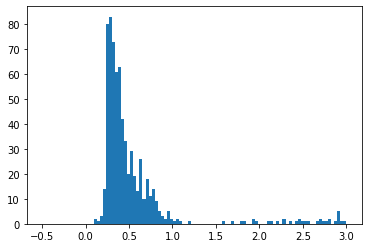

In [19]:
refcoord_ngc7296_V, coord_ngc7296_V = sep_check(imgwcs_ngc7296_V,srcs_ngc7296_V,refcat_ngc7296_V)

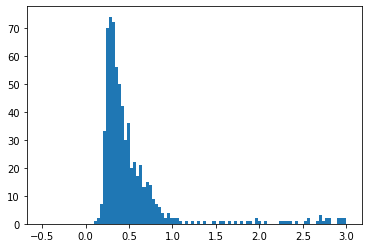

In [20]:
refcoord_ngc7296_B, coord_ngc7296_B = sep_check(imgwcs_ngc7296_B,srcs_ngc7296_B,refcat_ngc7296_B)

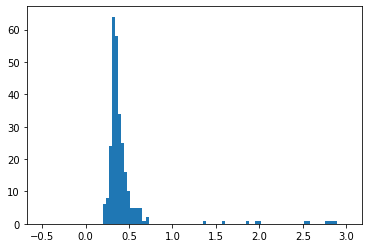

In [21]:
refcoord_king20_V, coord_king20_V = sep_check(imgwcs_king20_V,srcs_king20_V,refcat_king20_V)

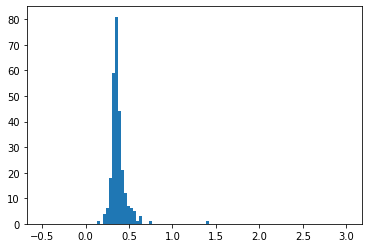

In [22]:
refcoord_king20_B, coord_king20_B = sep_check(imgwcs_king20_B,srcs_king20_B,refcat_king20_B)

It looks like the optimal match is less than 1.0 arcsec.  The following routine matches to within this tolerance

In [23]:
#take two lists of coordinates 
def match_src_ref(refcoord, coord, srcs, img, radasec = 1.0):
    rad = radasec * u.arcsec

    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_ref, indx, d2d, _ = coord.search_around_sky(refcoord, rad)
    nmatch = len(indx_ref)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs), rad))
    display_image(img, srcs=srcs[indx], calibrated=True)
    return indx, indx_ref

Found 642/2308 stars within 1.0 arcsec
Found 630/2070 stars within 1.0 arcsec


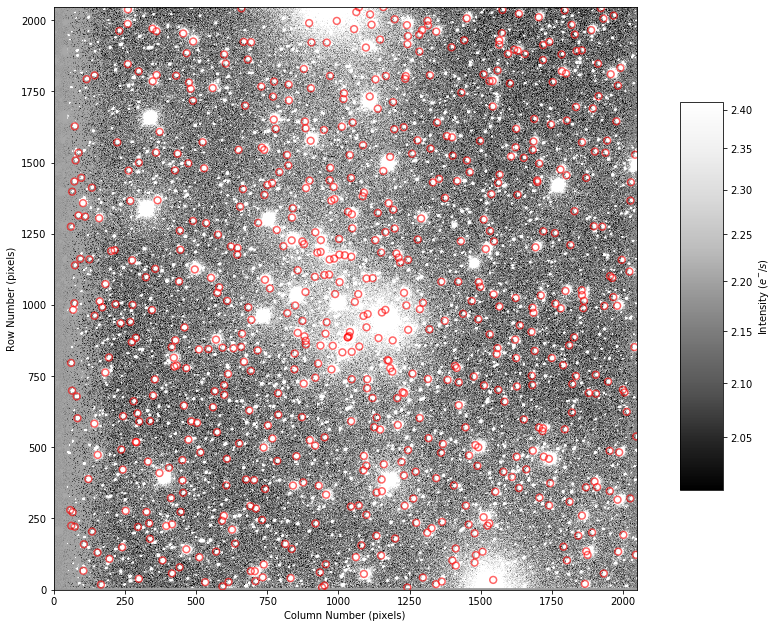

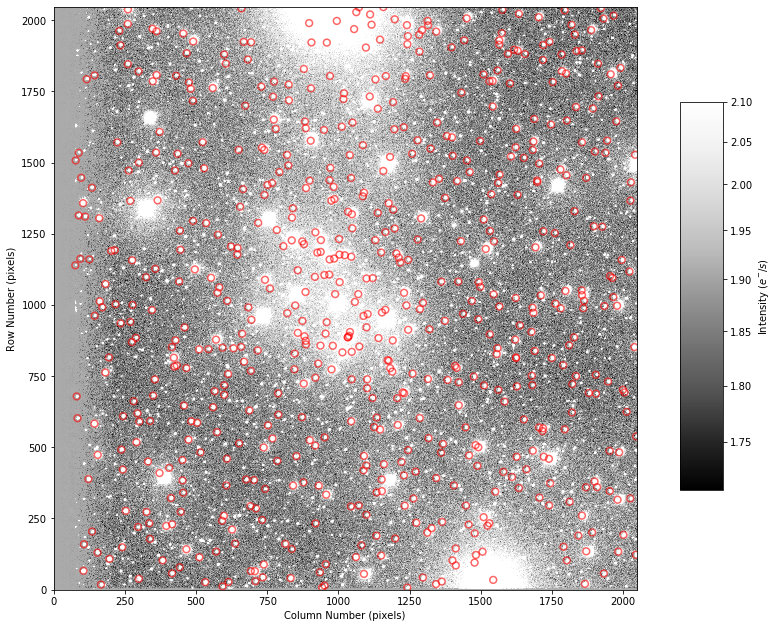

In [26]:
from astropy import units as u
indx_ngc7296_V, indx_ref_ngc7296_V = match_src_ref(refcoord_ngc7296_V, coord_ngc7296_V, srcs_ngc7296_V, img_ngc7296_V)
indx_ngc7296_B, indx_ref_ngc7296_B = match_src_ref(refcoord_ngc7296_B, coord_ngc7296_B, srcs_ngc7296_B, img_ngc7296_B)

Found 268/1284 stars within 1.0 arcsec
Found 269/719 stars within 1.0 arcsec


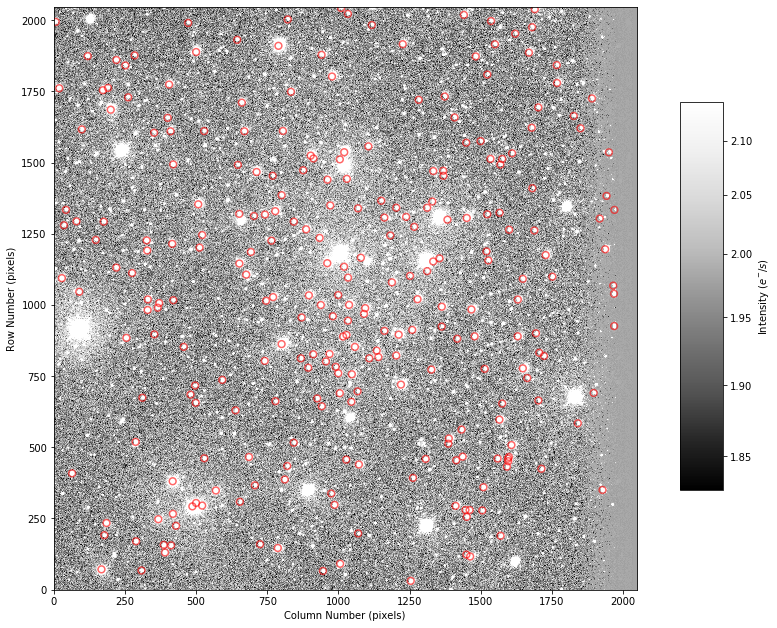

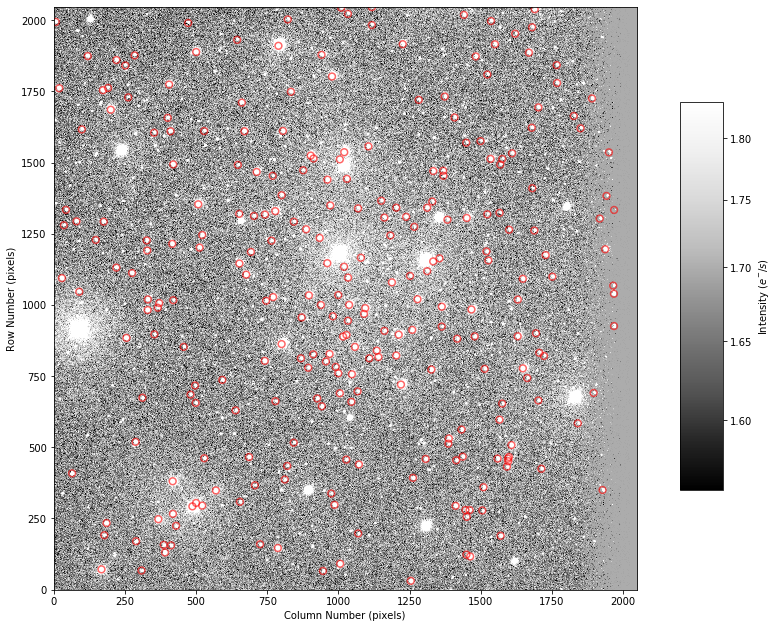

In [27]:
indx_king20_V, indx_ref_king20_V = match_src_ref(refcoord_king20_V, coord_king20_V, srcs_king20_V, img_king20_V)
indx_king20_B, indx_ref_king20_B = match_src_ref(refcoord_king20_B, coord_king20_B, srcs_king20_B, img_king20_B)


Now let's calculate the zeropoints for each image.  To compare our objects to those from Pan-STARRS we will need to correct for the effects of airmass.

We start by specifying the atmospheric extinction coefficient for each object.  This says for a typical atmosphere, how much the magnitude changes for an increase in airmass of 1.  We could have measured this using mutliple standard stars but will just assume a cannonical value for now.

In [28]:
def zp_meas(srcs, refcat, indx, indx_ref, hdr):
    kext = {'B': 0.4, 'V': 0.2}
    import numpy.ma as ma

    #this consists of the instrumental magnitude, which is the magnitude, including an airmass correction
    #but without a true zeropoint.  The second term says how the magnitude 
    #m(inst) = -2.5 * log(flux) - (sec z) * k
    instmag = srcs['mag'][indx].data - hdr['AIRMASS'] * kext[hdr['FILTER']]

    #the Pan-STARRS magnitudes for the same objects, as indicated using the indx_ref array
    psmag = refcat[hdr['FILTER']][indx_ref].data

    #calculate the median zeropoint defined as
    #psmag = -2.5 * log(flux) - (sec z) * k + ZP = m(inst) + ZP
    medzp = np.median(psmag - instmag)
    print(hdr['FILTER'],'zeropoint = ', medzp)
    print('Airmass in {} was {}'.format(hdr['FILTER'], hdr['AIRMASS']))
    return medzp

In [29]:
ZPV = zp_meas(srcs_ngc7296_V,refcat_ngc7296_V, indx_ngc7296_V, indx_ref_ngc7296_V,hdr_ngc7296_V)
ZPB = zp_meas(srcs_ngc7296_B,refcat_ngc7296_B, indx_ngc7296_B, indx_ref_ngc7296_B,hdr_ngc7296_B)
ZPV_KING20 = zp_meas(srcs_king20_V,refcat_king20_V, indx_king20_V, indx_ref_king20_V,hdr_king20_V)
ZPB_KING20 = zp_meas(srcs_king20_B,refcat_king20_B, indx_king20_B, indx_ref_king20_B,hdr_king20_B)

/home/s376r951/.conda/envs/python3env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


V zeropoint =  19.849246121645116
Airmass in V was 1.087689
B zeropoint =  20.76102347001946
Airmass in B was 1.091673
V zeropoint =  20.41466847934981
Airmass in V was 1.149429
B zeropoint =  20.971796795484906
Airmass in B was 1.152416


Now match the B and V-band catalogs together for this cluster, apply the zeropoints, and plot a CMD!

In [30]:
def make_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, ZPB, ZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + ZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + ZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    #print(magB-magV)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(magB-magV, magV, 'ro',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show


Found 2041/2070 stars within 1.0 arcsec


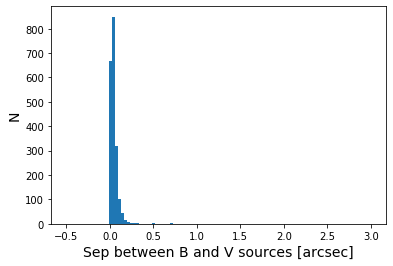

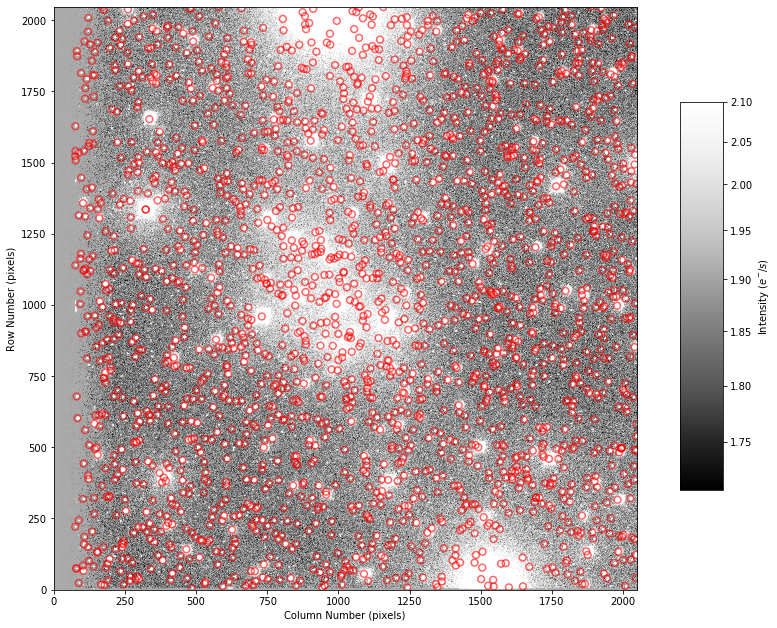

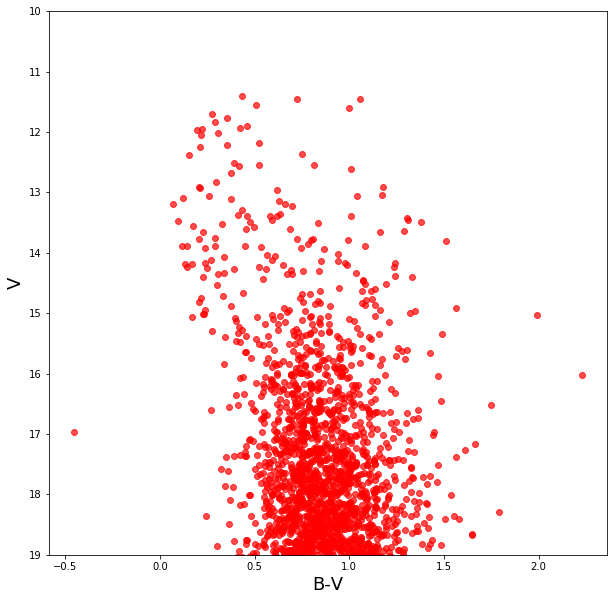

In [31]:
make_CMD(img_ngc7296_B, imgwcs_ngc7296_B, srcs_ngc7296_B,imgwcs_ngc7296_V, srcs_ngc7296_V, hdr_ngc7296_B, hdr_ngc7296_V, ZPB, ZPV, radasec = 1.0)

Found 718/719 stars within 1.0 arcsec


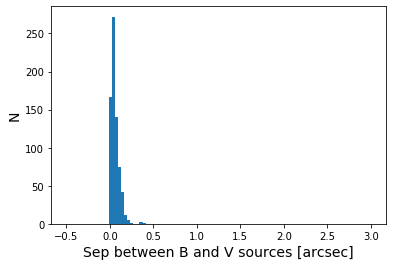

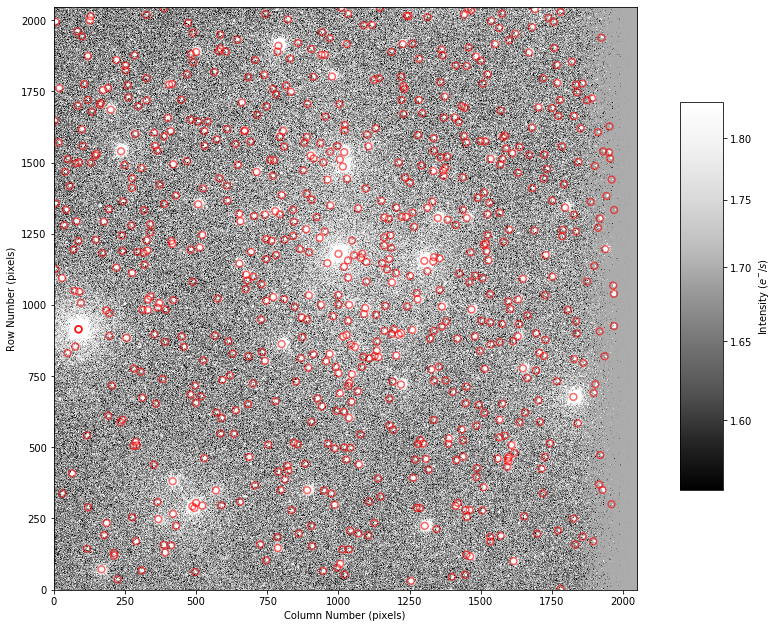

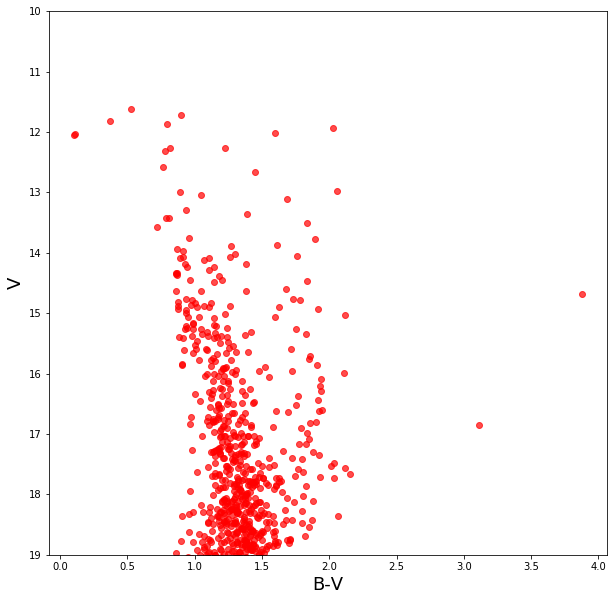

In [33]:
make_CMD(img_king20_B, imgwcs_king20_B, srcs_king20_B,imgwcs_king20_V, srcs_king20_V, hdr_king20_B, hdr_king20_V, ZPB_KING20, ZPV_KING20, radasec = 1.0)